# **Лекция 3: Теория Apache Spark — Философия и работа с RDD**

---

## **Часть 1: Архитектура Spark: Driver, Executor, DAG**

### **1.1 Исторический контекст: Почему Spark?**

**Hadoop MapReduce (2006-2014) — Эпоха дисковой обработки:**

```
Технологический стек Hadoop:
┌─────────────────────────────────────────┐
│         Пользовательские приложения     │
├─────────────────────────────────────────┤
│      MapReduce (единственная модель)    │
├─────────────────────────────────────────┤
│        HDFS (распределенная файловая    │
│              система на диске)          │
└─────────────────────────────────────────┘

Ограничения Hadoop MapReduce:

1. МНОГОЧИСЛЕННЫЕ ОПЕРАЦИИ С ДИСКОМ:
   Каждая стадия → Запись на HDFS → Чтение → Следующая стадия
   
   Пример пайплайна обработки данных:
   Данные → HDFS → Map → HDFS → Shuffle → HDFS → Reduce → HDFS
   
   Проблема: 90% времени тратится на ввод-вывод!

2. НИЗКАЯ ПРОИЗВОДИТЕЛЬНОСТЬ:
   • Задержка: минуты для простых запросов
   • Не подходит для: интерактивного анализа,
                       итеративных алгоритмов (машинное обучение),
                       потоковой обработки

3. СЛОЖНАЯ ПРОГРАММНАЯ МОДЕЛЬ:
   • Для сложных алгоритмов нужны цепочки Job'ов
   • Каждый Job — отдельное планирование и выполнение
   • Нет единого представления о вычислениях
```

**Apache Spark (2014-настоящее время) — Эпоха in-memory вычислений:**

```
Философия Spark: "Всё в памяти, единый движок"

┌─────────────────────────────────────────────────────────┐
│                  Apache Spark (единый движок)           │
├─────────────────────────────────────────────────────────┤
│  Spark SQL      │ Spark       │ MLlib       │ GraphX    │
│  (SQL запросы)  │ Streaming   │ (ML)        │ (графы)   │
├─────────────────────────────────────────────────────────┤
│              Spark Core (RDD + DAG Scheduler)           │
├─────────────────────────────────────────────────────────┤
│                 Кластерные менеджеры                    │
│          (YARN, Mesos, Kubernetes, Standalone)          │
└─────────────────────────────────────────────────────────┘

Преимущества Spark:
1. СКОРОСТЬ: До 100x быстрее Hadoop MapReduce in-memory
2. УНИВЕРСАЛЬНОСТЬ: Один движок для разных типов обработки
3. ПРОСТОТА: Единая модель программирования
```

### **1.2 Трехуровневая архитектура Spark**

**Архитектурная схема:**
```
                                Пользовательская программа
                                        │
                                        ▼
┌─────────────────────────────────────────────────────────────────┐
│                      УРОВЕНЬ 1: DRIVER PROGRAM                  │
│  (запускается на master-ноде или как отдельный процесс)         │
├─────────────────────────────────────────────────────────────────┤
│  Компоненты Driver:                                             │
│  • SparkContext: точка входа, соединение с кластером            │
│  • DAGScheduler: преобразует RDD граф в стадии задач            │
│  • TaskScheduler: отправляет задачи исполнителям                │
│  • SchedulerBackend: общается с менеджером кластера             │
└──────────────────────┬──────────────────────────────────────────┘
                       │
                       │ Запрос ресурсов / Статус выполнения
                       ▼
┌─────────────────────────────────────────────────────────────────┐
│                 УРОВЕНЬ 2: CLUSTER MANAGER                      │
│          (распределение ресурсов между приложениями)            │
├─────────────────────────────────────────────────────────────────┤
│  Варианты:                                                      │
│  • Standalone: простой встроенный менеджер Spark                │
│  • Apache YARN: стандарт Hadoop экосистемы                      │
│  • Apache Mesos: универсальный кластерный менеджер              │
│  • Kubernetes: современный стандарт для контейнеризации         │
└──────────────────────┬──────────────────────────────────────────┘
                       │
                       │ Выделение ресурсов / Запуск исполнителей
                       ▼
┌─────────────────────────────────────────────────────────────────┐
│                    УРОВЕНЬ 3: EXECUTORS                         │
│           (рабочие процессы на вычислительных нодах)            │
├─────────────────────────────────────────────────────────────────┤
│  Каждый Executor:                                               │
│  • JVM процесс на worker-ноде                                   │
│  • Запускает задачи (tasks) в потоках                           │
│  • Хранит данные в памяти/на диске                              │
│  • Отчитывается драйверу о статусе                              │
│                                                                 │
│  Executor 1           Executor 2           Executor N           │
│  ┌────────────┐      ┌────────────┐      ┌────────────┐         │
│  │ Task 1.1   │      │ Task 2.1   │      │ Task N.1   │         │
│  │ Task 1.2   │      │ Task 2.2   │      │ Task N.2   │         │
│  │ ...        │      │ ...        │      │ ...        │         │
│  │ Cache:     │      │ Cache:     │      │ Cache:     │         │
│  │ - RDD A    │      │ - RDD B    │      │ - RDD C    │         │
│  └────────────┘      └────────────┘      └────────────┘         │
└─────────────────────────────────────────────────────────────────┘
```

**Подробно о каждом компоненте:**

**A. Driver Program (Драйвер-программа):**
- **Роль**: "Мозг" приложения Spark
- **Место выполнения**: Обычно на отдельной ноде (не на рабочих нодах)
- **Функции**:
  1. **Создание SparkContext**: точка входа, устанавливает соединение
  2. **Преобразование кода в задачи**: разбивает вычисления на задачи
  3. **Планирование выполнения**: решает, какие задачи на какие ноды
  4. **Сбор результатов**: получает результаты от исполнителей
  5. **Обработка ошибок**: перепланирование при сбоях

**B. Cluster Manager (Менеджер кластера):**
- **Роль**: "Диспетчер ресурсов" (как операционная система для кластера)
- **Сравнение менеджеров**:

| Менеджер | Плюсы | Минусы | Когда использовать |
|----------|-------|--------|-------------------|
| **Standalone** | Простой, встроен в Spark | Ограниченные возможности | Тестирование, маленькие кластеры |
| **YARN** | Интеграция с Hadoop | Сложная настройка | Hadoop экосистема |
| **Mesos** | Универсальный, хорошая изоляция | Меньше популярности | Гетерогенные кластеры |
| **Kubernetes** | Контейнеризация | Интеграция | Cloud-native окружения |

**C. Executors (Исполнители):**
- **Роль**: "Рабочие лошадки", выполняют реальные вычисления
- **Архитектура исполнителя**:
  ```
  Executor JVM Process:
  ┌─────────────────────────────────────────┐
  │          Executor Memory Pool           │
  ├─────────────────────────────────────────┤
  │  Execution Memory (50%)                 │
  │  • Shuffle данные                       │
  │  • Join, aggregations                   │
  ├─────────────────────────────────────────┤
  │  Storage Memory (50%)                   │
  │  • Кэшированные RDD                     │
  │  • Broadcast переменные                 │
  ├─────────────────────────────────────────┤
  │  User Memory (reserved)                 │
  │  • Данные пользовательских функций      │
  └─────────────────────────────────────────┘
  ```

### **1.3 DAG (Directed Acyclic Graph) — революция в планировании вычислений**

**Что такое DAG?**
DAG (Directed Acyclic Graph) — ориентированный ациклический граф, который представляет вычисления как граф операций с зависимостями.

**Проблема, которую решает DAG:**  
Без DAG (как в Hadoop):
```
Задача: A → B → C → D
Выполнение: Запуск A → Завершение A → Запуск B → ...
           (последовательное планирование)
```

С DAG (в Spark):
```
Задача:    A      B        C
            ↘   ↙   ↘   ↙
              D        E
               ↘     ↙
                  F
                
Планирование:
Видит ВЕСЬ граф, может:
1. Объединить A и B в одну стадию
2. Запустить D и E параллельно
3. Оптимизировать перемещение данных
```

**Как строится DAG в Spark:**

```
Этапы построения DAG:
1. ПОЛЬЗОВАТЕЛЬСКИЙ КОД:
   rdd1 = sc.textFile(...)
   rdd2 = rdd1.flatMap(...)
   rdd3 = rdd2.map(...)
   rdd4 = rdd3.reduceByKey(...)

2. RDD LINEGE (наследование):
   RDD4 ← reduceByKey ← RDD3 ← map ← RDD2 ← flatMap ← RDD1

3. DAG SCHEDULER анализирует:
   • Какие операции можно объединить?
   • Где границы shuffle?
   • Как оптимально распределить?

4. Разбиение на STAGES (стадии):
   Stage 0: textFile → flatMap → map
   Stage 1: reduceByKey (требует shuffle)

5. Разбиение на TASKS (задачи):
   Stage 0: Task 0.1, Task 0.2, Task 0.3... (по партициям)
   Stage 1: Task 1.1, Task 1.2, Task 1.3...
```

**Ключевое понятие: Shuffle — граница между стадиями**

**Что такое Shuffle?**
Shuffle — процесс перераспределения данных между партициями, необходимый для операций, которые требуют группировки данных по ключу.

**Пример shuffle при reduceByKey:**
```
Данные до shuffle (по партициям):
Партиция 0: (key1, 1), (key2, 2), (key1, 3)
Партиция 1: (key2, 1), (key1, 2), (key3, 1)

Shuffle процесс:
1. Каждый executor записывает свою часть данных в локальные файлы
2. Эти файлы передаются по сети другим executors
3. Каждый executor читает данные для "своих" ключей

После shuffle:
Executor A: все key1 → (key1, [1, 3, 2])
Executor B: все key2 → (key2, [2, 1])
Executor C: все key3 → (key3, [1])
```

**Операции, вызывающие shuffle:**
- `reduceByKey()`, `groupByKey()`, `aggregateByKey()`
- `join()`, `cogroup()`, `intersection()`
- `distinct()`, `repartition()`, `coalesce(shuffle=True)`
- `sortBy()`, `sortByKey()`

**Операции БЕЗ shuffle (узкие зависимости):**
- `map()`, `filter()`, `flatMap()`
- `mapPartitions()`, `mapValues()`
- `union()`, `sample()`

### **1.4 Процесс выполнения приложения Spark**

**Полный цикл выполнения:**
```
1. ИНИЦИАЛИЗАЦИЯ:
   • Пользователь запускает приложение
   • Создается SparkContext
   • Подключение к Cluster Manager

2. ПОЛУЧЕНИЕ РЕСУРСОВ:
   • Запрос executors у Cluster Manager
   • Запуск JVM процессов на worker-нодах
   • Регистрация executors в SparkContext

3. ПРЕОБРАЗОВАНИЕ КОДА:
   • Код пользователя анализируется
   • Строится RDD lineage
   • DAGScheduler создает DAG
   • Разбиение на stages и tasks

4. ВЫПОЛНЕНИЕ ЗАДАЧ:
   • TaskScheduler отправляет tasks executors
   • Каждый executor запускает task в потоке
   • Выполнение пользовательского кода (функций)
   • Кэширование результатов если нужно

5. SHUFFLE (если требуется):
   • Запись промежуточных данных
   • Передача по сети
   • Чтение другими executors

6. СБОР РЕЗУЛЬТАТОВ:
   • Executors отправляют результаты драйверу
   • Драйвер агрегирует результаты
   • Возврат пользователю или сохранение

7. ЗАВЕРШЕНИЕ:
   • Освобождение ресурсов
   • Закрытие SparkContext
```

**Пример временной шкалы выполнения:**
```
Время  Операция
-----  -----------------------------------
 0ms   Запуск SparkContext
 50ms  Получение executors
 100ms Построение DAG
 150ms Stage 0: Задачи отправлены
 200ms Stage 0: Выполнение (map/filter)
 400ms Stage 0: Завершено, shuffle write
 600ms Stage 1: Shuffle read
 700ms Stage 1: Выполнение (reduce)
 800ms Stage 1: Завершено
 850ms Результаты собраны
 900ms Приложение завершено
```

**Демо 1.2: Сравнение производительности Spark vs Hadoop (концептуальное)**

Симулированное сравнение: in-memory vs disk-based
Размер данных | Spark-подобный | Hadoop-подобный | Ускорение
       1,000 |              0 |               3 |      9.0x
      10,000 |              1 |              10 |     13.1x
      50,000 |              4 |              46 |     12.7x
     100,000 |              7 |              90 |     12.3x
     200,000 |             15 |             184 |     12.5x


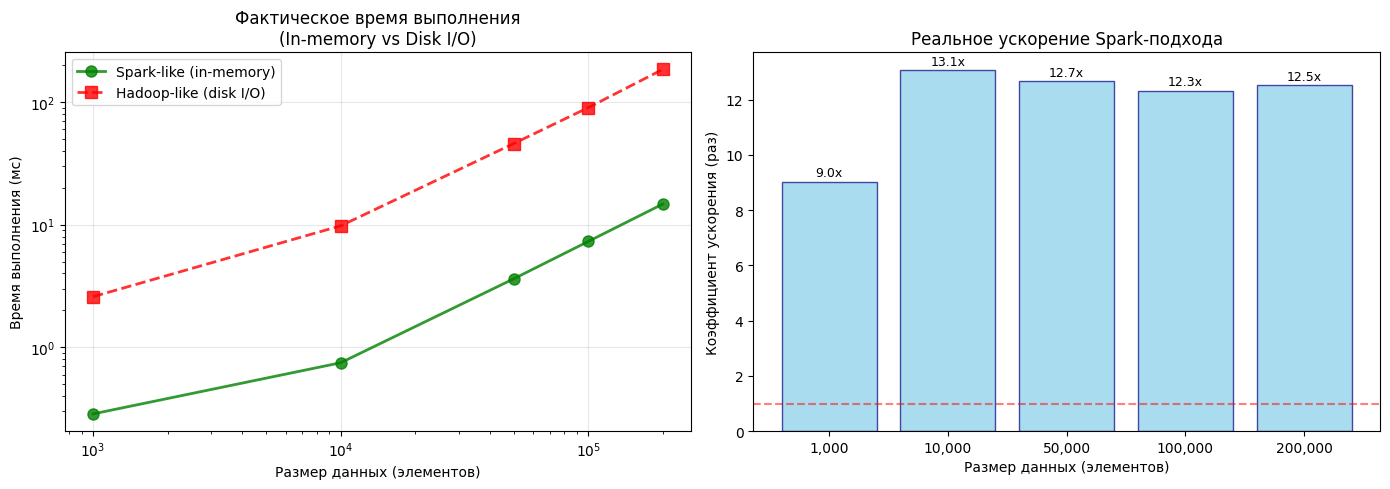

In [ ]:
import tempfile, time, os
import matplotlib.pyplot as plt
import numpy as np

print("Симулированное сравнение: in-memory vs disk-based")

def hadoop_like_processing(data):
    """Имитация Hadoop: каждая операция - запись на диск - чтение"""
    temp_files = []

    # операция 1: map (запись на диск)
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        for item in data:
            f.write(f"{item * 2}\n")
        temp_files.append(f.name)

    # чтение для операции 2
    with open(temp_files[-1], 'r') as f:
        data1 = [int(line.strip()) for line in f]

    # операция 2: filter (запись на диск)
    with tempfile.NamedTemporaryFile(mode='w', delete=False) as f:
        for item in data1:
            if item % 3 == 0:
                f.write(f"{item}\n")
        temp_files.append(f.name)

    # чтение для операции 3
    with open(temp_files[-1], 'r') as f:
        data2 = [int(line.strip()) for line in f]

    # операция 3: reduce
    result = sum(data2)

    # очистка
    for f in temp_files:
        os.unlink(f)

    return result

def spark_like_processing(data):
    """Имитация Spark: все операции в памяти (pipeline)"""
    # все операции в одном проходе по данным
    result = 0
    for item in data:
        transformed = item * 2      # map
        if transformed % 3 == 0:    # filter
            result += transformed   # reduce

    return result

# тестируем на разных объемах данных
data_sizes = [1000, 10000, 50000, 100000, 200000]
spark_times = []
hadoop_times = []

print("Размер данных | Spark-подобный | Hadoop-подобный | Ускорение")

for size in data_sizes:
    # тестовые данные
    test_data = list(range(size))

    # Spark-подход
    start = time.time()
    spark_result = spark_like_processing(test_data)
    spark_time = (time.time() - start) * 1000
    spark_times.append(spark_time)

    # Hadoop-подход
    start = time.time()
    hadoop_result = hadoop_like_processing(test_data)
    hadoop_time = (time.time() - start) * 1000
    hadoop_times.append(hadoop_time)

    # проверяем, что результаты одинаковы
    assert spark_result == hadoop_result, f"Результаты не совпадают: {spark_result} vs {hadoop_result}"

    speedup = hadoop_time / spark_time if spark_time > 0 else 1
    print(f"{size:12,} | {spark_time:14.0f} | {hadoop_time:15.0f} | {speedup:8.1f}x")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# график 1: абсолютное время
ax1.plot(data_sizes, spark_times, 'g-o', linewidth=2, markersize=8, label='Spark-like (in-memory)', alpha=0.8)
ax1.plot(data_sizes, hadoop_times, 'r--s', linewidth=2, markersize=8, label='Hadoop-like (disk I/O)', alpha=0.8)
ax1.set_xlabel('Размер данных (элементов)')
ax1.set_ylabel('Время выполнения (мс)')
ax1.set_title('Фактическое время выполнения\n(In-memory vs Disk I/O)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)

# график 2: относительное ускорение
ax2.bar(range(len(data_sizes)), [h/s for h, s in zip(hadoop_times, spark_times)],
        color='skyblue', edgecolor='navy', alpha=0.7)
ax2.set_xticks(range(len(data_sizes)))
ax2.set_xticklabels([f'{s:,}' for s in data_sizes])
ax2.set_xlabel('Размер данных (элементов)')
ax2.set_ylabel('Коэффициент ускорения (раз)')
ax2.set_title('Реальное ускорение Spark-подхода')
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Нет ускорения')

for i, (h, s) in enumerate(zip(hadoop_times, spark_times)):
    speedup = h / s
    ax2.text(i, speedup + 0.2, f'{speedup:.1f}x', ha='center', fontsize=9)

plt.tight_layout()
plt.show()



В РЕАЛЬНОМ КЛАСТЕРЕ ЭТА РАЗНИЦА ЕЩЕ БОЛЬШЕ:

1. Реальный Hadoop добавляет:  
   • Сетевая передача между узлами  
   • Сериализация/десериализация данных  
   • Задержки планирования Job'ов  

2. Реальный Spark добавляет преимущества:  
   • Оптимизация DAG (объединение операций)  
   • Локальность данных (data locality)  
   • Векторизованные операции (Tungsten)  
   • Adaptive Query Execution (Spark 3.0+)  

3. Типичное ускорение в production:  
   • Для iterative алгоритмов (ML): 50-100x  
   • Для ETL пайплайнов: 10-30x    
   • Для интерактивных запросов: 100-1000x  

## **Часть 2: RDD (Resilient Distributed Dataset) — концепция и свойства**

### **2.1 Фундаментальная идея RDD**

**RDD (Resilient Distributed Dataset)** — это **основная абстракция данных** в Spark, которая представляет собой **неизменяемую, распределенную коллекцию объектов**.

**Ключевые слова в определении:**

1. **Resilient (Устойчивый)**: Может восстанавливаться после сбоев
2. **Distributed (Распределенный)**: Данные разделены на части, распределены по узлам
3. **Dataset (Набор данных)**: Коллекция элементов одного типа

### **2.2 Исторический контекст: Почему RDD?**

**Проблемы существовавших систем (до 2010):**

**A. Системы с общей памятью:**
```
Проблема: Не масштабируются
Пример: MPI (Message Passing Interface)
┌─────────────────────────────────────────┐
│ Узел 1 │ Узел 2 │ Узел 3 │ Узел 4 │     │
│ [Данные]  [Данные]  [Данные]  [Данные]  │
└─────────────────────────────────────────┘
Все данные должны помещаться в память каждого узла
```

**B. Системы с распределенным хранилищем:**
```
Проблема: Медленно, сложно программировать
Пример: Hadoop MapReduce
┌──────────────────────────────────────────┐
│ HDFS: данные на диске, стабильно         │
│ MapReduce: каждая стадия → запись на диск│
└──────────────────────────────────────────┘
Высокая задержка, сложные алгоритмы требуют цепочек Job'ов
```

**C. Необходимость новой абстракции (2010):**
```
Требования:
1. Распределенность: данные больше, чем память одного узла
2. Отказоустойчивость: сбои узлов неизбежны в больших кластерах
3. Производительность: in-memory вычисления
4. Простота: единая модель программирования
```

**Решение: RDD (Resilient Distributed Dataset)**

### **2.3 Абстрактная модель RDD**

**Математическая модель:**
```
RDD = (T, P, D, F, L)

где:
T - тип элементов RDD
P - набор партиций {p₁, p₂, ..., pₙ}
D - зависимости между RDD (lineage)
F - функция вычисления: pᵢ → T*
L - опционально: предпочтительное размещение партиций
```

**Визуализация структуры RDD:**
```
                  ┌─────────────────────────────────────┐
                  │         RDD АБСТРАКЦИЯ              │
                  │  (логическое представление)         │
                  ├─────────────────────────────────────┤
                  │ МЕТАДАННЫЕ:                         │
                  │ • Тип данных: List[Int]             │
                  │ • Количество партиций: 4            │
                  │ • Lineage: ← map ← filter ← source  │
                  │ • Функция: f(partition_id) → данные │
                  └──────────────────┬──────────────────┘
                                     │
                 ┌───────────────────┴───────────────────┐
                 │      ФИЗИЧЕСКАЯ РЕАЛИЗАЦИЯ            │
                 │  (распределена по узлам кластера)     │
                 └───────────────────┬───────────────────┘
                                     │
    ┌──────────────┐  ┌──────────────┐  ┌──────────────┐
    │   УЗЕЛ 1     │  │   УЗЕЛ 2     │  │   УЗЕЛ 3     │
    ├──────────────┤  ├──────────────┤  ├──────────────┤
    │ Партиция 0   │  │ Партиция 1   │  │ Партиция 2   │
    │ [1, 2, 3]    │  │ [4, 5, 6]    │  │ [7, 8, 9]    │
    │              │  │              │  │              │
    │ Партиция 3   │  │              │  │              │
    │ [10, 11, 12] │  │              │  │              │
    └──────────────┘  └──────────────┘  └──────────────┘
```

### **2.4 Пять основных свойств RDD**

**Свойство 1: Набор партиций (Partitions)**

```
Определение: RDD разделен на независимые части - партиции.
Каждая партиция содержит подмножество данных RDD.

Пример:
RDD с 1,000,000 элементов, 4 партиции:
• Партиция 0: элементы 0-249,999
• Партиция 1: элементы 250,000-499,999
• Партиция 2: элементы 500,000-749,999
• Партиция 3: элементы 750,000-999,999

Значение:
• Партиции - единица параллелизма
• Каждая партиция обрабатывается отдельным потоком/задачей
• Распределение по узлам кластера
```

**Свойство 2: Зависимости между RDD (Dependencies)**

```
Определение: Каждый RDD знает свои "родительские" RDD,
из которых он был создан (lineage).

Типы зависимостей:
1. Narrow (узкие) зависимости:
   • Каждая партиция родительского RDD используется
     максимум одной партицией дочернего RDD
   • Пример: map, filter, union
   • Преимущество: нет shuffle, можно выполнять pipeline

2. Wide (широкие) зависимости:
   • Каждая партиция родительского RDD используется
     несколькими партициями дочернего RDD
   • Пример: reduceByKey, groupByKey, join
   • Требует shuffle (перемешивания данных)

Визуализация:
map (narrow):     reduceByKey (wide):
[P1] → [P1']      [P1] → [P1', P2']
[P2] → [P2']      [P2] → [P1', P2']
[P3] → [P3']      [P3] → [P1', P2']
```

**Свойство 3: Функция вычисления (Compute Function)**

```
Определение: Для каждой партиции определена функция,
которая вычисляет данные этой партиции.

Типы функций:
1. Функции трансформаций: создают новый RDD
   Пример:
   def mapFunction(iterator):
       for element in iterator:
           yield element * 2

2. Функции действий: возвращают результат
   Пример:
   def reduceFunction(iterator):
       total = 0
       for element in iterator:
           total += element
       return total

Важно: Функции выполняются на исполнителях (executors),
а не на драйвере!
```

**Свойство 4: Партиционер (Partitioner) - опционально**

```
Определение: Определяет, как данные распределены по партициям.
Используется только для Pair RDD (RDD[(K, V)]).

Типы партиционеров:
1. HashPartitioner (по умолчанию):
   • partition = hash(key) % numPartitions
   • Гарантирует: одинаковые ключи → одна партиция

2. RangePartitioner:
   • Распределяет по диапазонам ключей
   • Полезно для сортировки, диапазонных запросов

Пример:
Данные: [("a",1), ("b",2), ("c",3), ("a",4)]
HashPartitioner с 2 партициями:
• Партиция 0 (hash("a")%2=0, hash("c")%2=0): ("a",1), ("c",3), ("a",4)
• Партиция 1 (hash("b")%2=1): ("b",2)
```

**Свойство 5: Предпочтительные локации (Preferred Locations) - опционально**

```
Определение: Для каждой партиции может быть указано,
на каких узлах её лучше вычислять (data locality).

Типы локальности:
1. PROCESS_LOCAL: данные в том же процессе JVM
2. NODE_LOCAL: данные на том же узле
3. RACK_LOCAL: данные в той же стойке
4. ANY: любые данные (медленнее)

Пример использования:
При чтении из HDFS: партиции располагаются ближе к данным
• Если данные на Узле А, то задачи для этих данных
  планируются на Узле А (минимизация передачи по сети)
```

### **2.5 Lineage (родословная) — сердце отказоустойчивости**

**Концепция Lineage:**
```
Lineage - это запись о том, как RDD был создан
из других RDD или входных данных.

```

**Как работает Lineage:**

```
Пример вычислений:
Исходные данные → трансформация 1 → трансформация 2 → результат

Lineage граф:
          ┌─────────┐     ┌─────────┐     ┌─────────┐
Исходные  │         │     │         │     │         │ Результат
данные    │  Text   │────▶│  Words  │────▶│  Counts │ RDD
          │  RDD    │     │  RDD    │     │  RDD    │
          └─────────┘     └─────────┘     └─────────┘
            textFile        flatMap        reduceByKey

Запись lineage:
RDD[Counts]:
• Родитель: RDD[Words] через reduceByKey
• Его родитель: RDD[Text] через flatMap
• Исходные: файл "data.txt"
```

**Преимущества lineage:**

1. **Отказоустойчивость**: При сбое узла можно пересчитать потерянные партиции
2. **Оптимизация**: Spark видит весь граф вычислений
3. **Отладка**: Можно проследить происхождение данных
4. **Минимизация сохранения**: Не нужно постоянно сохранять промежуточные данные

**Пример восстановления при сбое:**
```
Предположим, Узел 2 с партицией 1 сломался:

До сбоя:
Узел 1: [Партиция 0: данные A] ← вычислена из файла часть 1
Узел 2: [Партиция 1: данные B] ← вычислена из файла часть 2
Узел 3: [Партиция 2: данные C] ← вычислена из файла часть 3

После сбоя:
Spark смотрит lineage партиции 1:
• Видит: партиция 1 создана из части 2 файла "data.txt"
• Пересчитывает: читает часть 2 файла → вычисляет заново
• Размещает на свободном узле (например, Узел 1)

Важно: Пересчитывается ТОЛЬКО потерянная партиция,а не весь RDD!
```

### **2.6 Неизменяемость (Immutability) — философский принцип**

**Почему RDD неизменяемы?**

**A. Теоретическое обоснование:**
```
Функциональное программирование:
• Неизменяемые структуры → детерминированность
• Нет side effects → проще распараллеливать
• Легче рассуждать о программе
```

**B. Практические преимущества:**

1. **Безопасность в многопоточной среде**:
   ```python
   # Проблема изменяемых данных:
   data = [1, 2, 3]
   
   # Поток 1: data.append(4)
   # Поток 2: data.remove(2)
   # Результат: гонка данных, неопределенное поведение
   
   # Решение с неизменяемыми RDD:
   rdd1 = sc.parallelize([1, 2, 3])
   rdd2 = rdd1.map(lambda x: x * 2)  # Новый RDD, старый не меняется
   # Потокобезопасно: каждый поток работает со своей копией
   ```

2. **Оптимизация через переиспользование**:
   ```python
   # Неизменяемость позволяет кэшировать:
   base_rdd = sc.textFile("data.txt")  # Неизменяемый
   processed = base_rdd.map(...).filter(...)
   
   # Многие вычисления могут использовать base_rdd
   analysis1 = base_rdd.filter(lambda x: "error" in x)
   analysis2 = base_rdd.filter(lambda x: "warning" in x)
   # base_rdd не меняется, можно безопасно переиспользовать
   ```

3. **Упрощение отладки**:
   ```
   Состояние 1: RDD_A = [1, 2, 3]
   Трансформация: RDD_B = RDD_A.map(x → x*2)
   Состояние 2: RDD_A = [1, 2, 3] (не изменился!)
                 RDD_B = [2, 4, 6] (новый RDD)
   
   Легко отследить: каждое состояние фиксировано
   ```

**C. Как достигается неизменяемость:**

1. **Все трансформации создают новые RDD**
2. **Данные партиций не меняются после создания**
3. **Изменения только через создание новых RDD в lineage**

### **2.7 Создание RDD: три основных способа**

**Способ 1: Параллелизация коллекции (в памяти)**

Коллекция разбивается на партиции, распределяется по узлам  
Хорошо для: небольших данных, тестирования, прототипирования

```python
data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
rdd = sc.parallelize(data, numSlices=4)
```
Что происходит внутри:
1. Данные сериализуются
2. Разбиваются на 4 партиции: [1,2,3], [4,5,6], [7,8], [9,10]
3. Отправляются на executors
4. Создается lineage: ParallelCollectionRDD

---

**Способ 2: Чтение из внешнего хранилища**


Чтение распределенных данных (HDFS, S3, локальные файлы)
Данные уже распределены, Spark лишь организует доступ

```python
rdd = sc.textFile("hdfs://path/to/file.txt")
```
Что происходит внутри:
1. Spark определяет схему файла (размер, формат)
2. Разбивает на партиции (по умолчанию: блоки HDFS)
3. Для каждой партиции запоминает: "читать байты X-Y из файла"
4. Создается lineage: HadoopRDD

---

**Способ 3: Преобразование существующих RDD**


Самый частый способ - через трансформации  
Новый RDD наследует lineage от родительского

```python
rdd1 = sc.parallelize([1, 2, 3])
rdd2 = rdd1.map(lambda x: x * 2)  # Новый RDD
rdd3 = rdd2.filter(lambda x: x > 3)  # Еще один RDD
```

Lineage:  
 rdd3 ← filter ← rdd2 ← map ← rdd1 ← parallelize


### **2.8 Типы данных в RDD**

**A. Простые типы:**
```python
# примитивы Python/Java/Scala
int_rdd = sc.parallelize([1, 2, 3])        # RDD[Int]
float_rdd = sc.parallelize([1.5, 2.7])     # RDD[Float]
string_rdd = sc.parallelize(["a", "b"])    # RDD[String]
```

**B. Составные типы:**
```python
# кортежи (tuples)
tuple_rdd = sc.parallelize([(1, "a"), (2, "b")])  # RDD[(Int, String)]

# списки/коллекции
list_rdd = sc.parallelize([[1, 2], [3, 4]])  # RDD[List[Int]]

# словари/мапы
dict_rdd = sc.parallelize([{"a": 1}, {"b": 2}])  # RDD[Dict]
```

**C. Пользовательские типы:**
```python
# любые сериализуемые объекты
class Person:
    def __init__(self, name, age):
        self.name = name
        self.age = age

people_rdd = sc.parallelize([
    Person("Alice", 30),
    Person("Bob", 25)
    ])  
# RDD[Person]
```

**D. Pair RDD (особый случай):**

RDD пар (ключ, значение)  
Особые свойства: поддержка партицирования по ключу
```python
pair_rdd = sc.parallelize([("a", 1), ("b", 2)])  # RDD[(String, Int)]
```
Автоматически получает HashPartitioner  
Поддерживает специальные операции: reduceByKey, groupByKey и т.д.


### **2.9 Глубокое понимание: Как RDD хранятся в памяти**

**Физическое представление RDD:**

```
Уровень 1: JVM Heap Memory
┌─────────────────────────────────────────┐
│        Executor JVM Process             │
├─────────────────────────────────────────┤
│  Execution Memory Pool (50%)            │
│  • Shuffle данные                       │
│  • Join, aggregation буферы             │
├─────────────────────────────────────────┤
│  Storage Memory Pool (50%)              │
│  • Кэшированные RDD                     │
│  • Broadcast переменные                 │
│  • Сериализованные/десериализованные    │
├─────────────────────────────────────────┤
│  User Memory (Reserved)                 │
│  • Данные пользовательских функций      │
│  • Внутренние структуры                 │
└─────────────────────────────────────────┘

Уровень 2: Хранение элементов RDD
Вариант 1: Десериализованные объекты (MEMORY_ONLY)
• Элементы как Java/Scala/Python объекты
• Быстрый доступ, но много памяти
• Подходит для: частого доступа, маленьких данных

Вариант 2: Сериализованные байты (MEMORY_ONLY_SER)
• Элементы как сериализованные байты
• Меньше памяти, но overhead на сериализацию
• Подходит для: больших данных, редкого доступа

Вариант 3: На диске (DISK_ONLY)
• Элементы на локальном диске исполнителя
• Медленно, но много места
• Подходит для: очень больших данных
```

### **2.9 Эволюция RDD в экосистеме Spark**

**Хронология развития:**

**2010: Идея RDD (исследовательская работа AMPLab, UC Berkeley)**
- Первая публикация: "Resilient Distributed Datasets: A Fault-Tolerant Abstraction for In-Memory Cluster Computing"
- Основные идеи: lineage, in-memory вычисления

**2012: Spark 0.6 (первый open source релиз)**
- Базовые RDD операции
- Поддержка Scala

**2013: Spark 0.7**
- Python API (PySpark)
- Основные трансформации и действия

**2014: Spark 1.0 (первый production-ready релиз)**
- Стабильный RDD API
- Java API
- Поддержка YARN

**2015: Spark 1.3 (появление DataFrame)**
- RDD остается, но DataFrame становится предпочтительным API
- Catalyst optimizer для DataFrame

**2016: Spark 2.0**
- Unified API (DataFrame = Dataset[Row])
- RDD для низкоуровневый контроль, DataFrame для высокоуровневые оптимизаций

**2020: Spark 3.0**
- Улучшения производительности RDD
- Лучшая интеграция с Python


Когда использовать RDD:
1. Кастомные алгоритмы, не выразимые через DataFrame API
2. Работа с неструктурированными данными (текст, графы)
3. Требуется полный контроль над партицированием
4. Унаследованный код на RDD
5. Образовательные цели (понимание основ Spark)


---

1. **RDD — фундаментальная абстракция** Spark, основанная на пяти свойствах: партиции, зависимости, функция вычисления, партиционер, предпочтительные локации

2. **Неизменяемость — философский принцип**, обеспечивающий безопасность, упрощающий отладку и позволяющий оптимизации

3. **Lineage — механизм отказоустойчивости**, позволяющий пересчитывать данные без постоянного сохранения

4. **RDD существуют на двух уровнях**: логическое представление (абстракция) и физическое распределение по узлам кластера

5. **Хотя DataFrame/Spark SQL стали основным API**, понимание RDD необходимо для глубокого понимания Spark и решения сложных задач

6. **RDD — это не просто техническая деталь**, а выражение философии Spark: распределенные, отказоустойчивые, функциональные вычисления

---

## **Часть 3: Трансформации vs Действия: ленивые вычисления**

### **3.1 Фундаментальная парадигма: Ленивые вычисления (Lazy Evaluation)**

**Что такое ленивые вычисления?**
```
Ленивые вычисления (Lazy Evaluation) — стратегия отложенного выполнения,
при которой вычисления не производятся до тех пор,
пока не потребуется их результат.

Противоположность: энергичные вычисления (Eager Evaluation) —
вычисления производятся немедленно при определении.
```

### **3.2 Зачем нужны ленивые вычисления в распределённых системах?**

**Проблемы энергичных вычислений (как в Hadoop):**

1. **Ненужные вычисления:**
   ```python
   # Пример энергичных вычислений:
   data = read_huge_file()          # СРАЗУ читаем весь файл (дорого!)
   filtered = filter_data(data)     # СРАЗУ фильтруем
   result = filtered.take(10)       # Нужно только 10 элементов
   # Проблема: прочитали и отфильтровали всё, хотя нужно было всего 10
   ```

2. **Отсутствие оптимизации:**
   ```python
   # Нельзя увидеть весь план вычислений заранее
   step1 = expensive_operation(data)
   step2 = another_operation(step1)
   result = final_operation(step2)
   # Каждая операция выполняется сразу, нельзя переупорядочить
   ```

3. **Избыточное использование ресурсов:**
   ```
   Каждая промежуточная операция → сохранение результата
   → трата памяти/диска на данные, которые могут не понадобиться
   ```

   **Решение Spark: Ленивые вычисления + DAG**

### **3.3 Трансформации (Transformations) — Ленивые операции**

Трансформации — операции, которые создают **новый RDD** из существующего.
Они **не выполняются немедленно**, а лишь **запоминаются** в lineage.

**Ключевые характеристики трансформаций:**
1. **Создают новый RDD**
2. **Ленивые (не выполняются сразу)**
3. **Записываются в lineage**
4. **Два типа: узкие (narrow) и широкие (wide)**

**Категории трансформаций:**

**A. Узкие трансформации (Narrow Transformations):**

Каждая партиция входного RDD используется
максимум одной партицией выходного RDD.
НЕ требуют shuffle (перемешивания данных).

| Трансформация | Пример вызова | Что делает |
| :--- | :--- | :--- |
| **`map(func)`** | `result = rdd.map(lambda x: x * 2)` | Умножает каждый элемент на 2 |
| **`filter(func)`** | `result = rdd.filter(lambda x: x > 5)` | Оставляет элементы больше 5 |
| **`flatMap(func)`** | `result = rdd.flatMap(lambda x: x.split())` | Разбивает строки на слова |
| **`mapPartitions(func)`** | `result = rdd.mapPartitions(lambda part: [sum(part)])` | Суммирует элементы в каждой партиции |
| **`union(otherRDD)`** | `result = rdd1.union(rdd2)` | Объединяет два RDD в один |

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("Demo").getOrCreate()
sc = spark.sparkContext

# создаем RDD для демонстрации
rdd = sc.parallelize([1, 2, 3, 4, 5])
rdd2 = sc.parallelize([6, 7, 8])
text_rdd = sc.parallelize(["hello world", "spark demo"])

# примеры вызова каждой трансформации:
mapped = rdd.map(lambda x: x * 2)  # умножаем на 2
filtered = rdd.filter(lambda x: x > 2)  # фильтруем > 2
flat_mapped = text_rdd.flatMap(lambda x: x.split())  # разбиваем на слова
partition_sum = rdd.mapPartitions(lambda part: [sum(part)])  # сумма партиции
unioned = rdd.union(rdd2)  # объединяем RDD

print("map:", mapped.collect())
print("filter:", filtered.collect())
print("flatMap:", flat_mapped.collect())
print("mapPartitions:", partition_sum.collect())
print("union:", unioned.collect())

map: [2, 4, 6, 8, 10]
filter: [3, 4, 5]
flatMap: ['hello', 'world', 'spark', 'demo']
mapPartitions: [3, 12]
union: [1, 2, 3, 4, 5, 6, 7, 8]


**B. Широкие трансформации (Wide Transformations):**
```
Каждая партиция входного RDD может использоваться
несколькими партициями выходного RDD.
Требуют SHUFFLE (перемешивания данных) — дорогая операция!
```

**Основные широкие трансформации:**

| Трансформация | Вызов | Что делает | Особенности |
| :--- | :--- | :--- | :--- |
| **`groupByKey()`** | `rdd.groupByKey()` | Группирует ВСЕ значения по ключу в список. | **Опасно!** Может переполнить память. Почти всегда лучше `reduceByKey`. |
| **`reduceByKey(func)`** | `rdd.reduceByKey(lambda a,b: a+b)` | Сворачивает значения для каждого ключа функцией (например, суммирует). | **Эффективно!** Частичная агрегация до shuffle уменьшает объем данных. |
| **`distinct()`** | `rdd.distinct()` | Удаляет дубликаты элементов. | Под капотом использует `reduceByKey`. Всегда вызывает shuffle. |
| **`join(otherRDD)`** | `rdd1.join(rdd2)` | Внутреннее соединение двух RDD по ключу (как SQL JOIN). | Для больших данных используйте `broadcast join`, если один RDD мал. |
| **`repartition(N)`** | `rdd.repartition(8)` | Полное перемешивание для изменения числа партиций. | **Всегда shuffle!** Для уменьшения партиций используйте `coalesce()`. |

---

### **3.4 Действия (Actions) — Энергичные операции**

**Определение:**
Действия — операции, которые **возвращают результат** в драйвер-программу
или **сохраняют данные** во внешнюю систему.
Они **запускают выполнение** всего lineage (графа вычислений).

**Ключевые характеристики действий:**
1. **Запускают вычисления** (триггер выполнения)
2. **Возвращают значения** в драйвер или сохраняют данные
3. **Энергичные** (выполняются немедленно при вызове)

**Основные действия:**


| Действие | Вызов | Возвращает в драйвер | Особенности / Когда использовать |
| :--- | :--- | :--- | :--- |
| **`collect()`** | `rdd.collect()` | **Все элементы** (список) | **Опасно!** Только для маленьких данных. |
| **`take(n)`** | `rdd.take(5)` | **Первые n** элементов (список) | Безопаснее для отладки. Не гарантирует порядок. |
| **`takeOrdered(n)`** | `rdd.takeOrdered(5)` | **n наименьших** элементов (список) | Для топ-N. Можно задать ключ сортировки (`key=lambda x: -x`). |
| **`first()`** | `rdd.first()` | **Первый** элемент | Эквивалент `take(1)[0]`. |
| **`count()`** | `rdd.count()` | **Число** (int) | Подсчет всех элементов. |
| **`countByKey()`** | `rdd.countByKey()` | **Словарь** {ключ: кол-во} | Для парных RDD. Возвращает стандартный `dict`. |
| **`reduce(func)`** | `rdd.reduce(lambda a,b: a+b)` | **Один** результат агрегации | Требует **ассоциативной** функции (например, сложение). |
| **`fold(zero, func)`** | `rdd.fold(0, lambda a,b: a+b)` | **Один** результат агрегации | `reduce` с **начальным значением** для каждой партиции. |
| **`aggregate(zero, seq, comb)`** | `rdd.aggregate((0,0), seq, comb)` | **Один** результат (любого типа) | Самый гибкий. Позволяет разный тип для промежуточного и финального результата (например, для вычисления среднего). |

---




| Действие | Вызов | Что делает | Особенности |
| :--- | :--- | :--- | :--- |
| **`saveAsTextFile(path)`** | `rdd.saveAsTextFile("/path")` | Сохраняет RDD как текстовые файлы, **по одному файлу на партицию**. | Использует HDFS/S3 пути. **Не перезаписывает** существующую папку. |
| **`saveAsSequenceFile(path)`** | `pair_rdd.saveAsSequenceFile("/path")` | Сохраняет RDD пар `(key, value)` в Hadoop **SequenceFile**. | Эффективный бинарный формат. Требует ключи и значения, конвертируемые в Hadoop Writable. |
| **`saveAsObjectFile(path)`** | `rdd.saveAsObjectFile("/path")` | Сохраняет RDD, используя **сериализацию Java объектов**. | Менее эффективен, но может хранить любые сериализуемые объекты. |
| **`foreach(func)`** | `rdd.foreach(lambda x: ...)` | **Применяет функцию** к каждому элементу на стороне executor. | Используется для **побочных эффектов** (запись в БД, API). Функция **должна быть сериализуемой**. |


Эти методы являются **действиями (actions)** — они запускают вычисления графа RDD. Их основная цель — **вывод данных** или **выполнение операций с побочными эффектами**, а не возврат результата в вашу программу.



###  **Что оптимизирует Spark благодаря ленивым вычислениям**

| Оптимизация | Как это работает | Выгода |
| :--- | :--- | :--- |
| **Пайплайн (Pipelining)** | Узкие трансформации (map, filter) объединяются и выполняются **за один проход** по данным, без сохранения промежуточных результатов. | **Скорость** и **экономия памяти**. |
| **Объединение (Fusion) операций** | Несколько `map` подряд (`rdd.map(f1).map(f2)`) автоматически сворачиваются в один `map` (`rdd.map(lambda x: f2(f1(x)))`). | Уменьшение накладных расходов. |
| **Умное планирование стадий (Stage Creation)** | Весь граф вычислений (DAG) делится на **стадии (stages)**. Граница стадии — только перед **широкой (shuffle)** трансформацией. Все узкие операции в рамках одной стадии пайплайнятся. | Минимизация дорогостоящих операций **shuffle** и максмимальный параллелизм. |
| **Predicate Pushdown (для DataFrame)** | При чтении из форматов вроде Parquet/ORC, фильтры (`df.filter(...)`) могут быть применены **на этапе чтения** данных с диска. | Резкое **сокращение объема** загружаемых данных. |

### **Потенциальные проблемы ленивых вычислений и их решения**

| Проблема | Пример | Решение / Что делать |
| :--- | :--- | :--- |
| **Ошибки обнаруживаются поздно** | Ошибка в функции внутри `map()` выскочит только при вызове действия (`.count()`) через долгое время после определения. | 1. **Тестируйте функции** на малых локальных данных. <br> 2. Используйте `rdd.take(1)` для быстрой проверки. |
| **Неожиданный расход памяти** | Вызов `persist()` на промежуточном RDD, который нигде не используется, запустит вычисления и зря займет память. | Четко планируйте **точки материализации**. Кэшируйте только RDD, которые используются многократно. |
| **Сложность отладки** | Длинная цепочка трансформаций падает с неочевидным стектрейсом. | 1. Используйте `.toDebugString()` для просмотра графа. <br> 2. **Разбивайте** сложные цепочки на логические этапы. |
| **Отсутствие явного прогресса** | Программа долго «думает», не показывая прогресса, а затем запускает все вычисления разом. | Мониторьте **Spark UI** (обычно на `http://localhost:4040`) для наблюдения за стадиями и задачами. |




---

1. **Ленивые вычисления — это не баг, а фича:** фундаментальный принцип, позволяющий Spark оптимизировать выполнение.

2. **Трансформации vs Действия:** критически важное различие, которое определяет, когда вычисления происходят.

3. **DAG — результат ленивости:** потому что трансформации не выполняются сразу, Spark может построить полный граф вычислений и оптимизировать его.

4. **Оптимизации через ленивость:** пайплайнинг, объединение операций, predicate pushdown — всё это возможно благодаря тому, что вычисления отложены.

5. **Практические следствия:**
   - Избегать множественных действий
   - Использовать кэширование для переиспользуемых RDD
   - Объединять агрегации через `aggregate()`
   - Помнить, что ошибки проявляются только при действиях

6. **Единая модель:** ленивые вычисления работают одинаково во всех компонентах Spark (RDD, DataFrame, Streaming), что делает обучение последовательным.

---


## **Часть 4: Парные RDD и агрегации (reduceByKey vs groupByKey)**

### **4.1 Введение в Pair RDD (RDD пар ключ-значение)**

**Что такое Pair RDD?**
```
Pair RDD — это специальный тип RDD, где каждый элемент представляет собой
пару (ключ, значение). Ключ используется для распределения данных
и выполнения операций агрегации.

Формально: RDD[(K, V)] где K — тип ключа, V — тип значения
```

**Зачем нужны Pair RDD?**
1. **Группировка:** Объединение значений по общему ключу
2. **Агрегация:** Вычисление статистик по группам
3. **Соединение:** Объединение нескольких наборов данных
4. **Сортировка:** Упорядочивание данных по ключу
5. **Распределение:** Контроль над размещением данных в кластере

### **4.2 Создание Pair RDD**

**Способ 1: Преобразование существующего RDD**

Из обычного RDD
```python
rdd = sc.parallelize(["apple", "banana", "apple", "orange"])
pair_rdd = rdd.map(lambda x: (x, 1))  # RDD[(String, Int)]
# [("apple", 1), ("banana", 1), ("apple", 1), ("orange", 1)]
```

**Способ 2: Прямое создание из пар**

Непосредственно из пар элементов
```python
data = [("a", 1), ("b", 2), ("a", 3)]
pair_rdd = sc.parallelize(data)  # RDD[(String, Int)]
```

**Способ 3: Из файлов ключ-значение**

Чтение SequenceFile (формат Hadoop)
```python
pair_rdd = sc.sequenceFile("hdfs://path/data",
                          "org.apache.hadoop.io.Text",
                          "org.apache.hadoop.io.IntWritable")

Преобразование типов Hadoop в Python
pair_rdd = pair_rdd.map(lambda x: (x[0].toString(), x[1].get()))
```

### 4.3 Трансформации

---

### **A. Трансформации над значениями (ключи не меняются)**

Эти операции не вызывают shuffle, так как ключи (и, следовательно, партиционирование) остаются прежними.

| Трансформация | Вызов | Что делает | Особенности |
| :--- | :--- | :--- | :--- |
| **`mapValues(func)`** | `pair_rdd.mapValues(lambda x: x*10)` | Применяет функцию **только к значению**, ключ сохраняется. | **Оптимально!** Не меняет партиционирование и не вызывает shuffle. |
| **`flatMapValues(func)`** | `pair_rdd.flatMapValues(lambda x: x)` | Применяет функцию к значению и «разглаживает» результат, оставляя ключи. | Полезно, когда значение — список. Ключ дублируется для каждого элемента. |

---

### **B. Группировка и агрегация (вызывают shuffle)**

Это самые важные и часто используемые операции. Выбор метода напрямую влияет на производительность.

| Трансформация | Вызов | Что делает | Когда использовать |
| :--- | :--- | :--- | :--- |
| **`groupByKey()`** | `pair_rdd.groupByKey()` | Собирает **все значения** для каждого ключа в один итератор (список). | **Избегать!** Почти всегда приводит к `OutOfMemoryError`. Используйте `reduceByKey` или `aggregateByKey`. |
| **`reduceByKey(func)`** | `pair_rdd.reduceByKey(lambda a,b: a+b)` | Агрегирует значения для каждого ключа с помощью **ассоциативной и коммутативной** функции (сложение, максимум). | **Основной выбор** для простой агрегации (сумма, счётчик). Частичная агрегация (`combine`) на маппере уменьшает данные для shuffle. |
| **`aggregateByKey(zero, seq, comb)`** | `pair_rdd.aggregateByKey((0,0), seq, comb)` | Более общая версия `reduceByKey`. Позволяет **разный тип** для аккумулятора и возвращаемого значения. | Для сложной агрегации (например, вычисление среднего: `(сумма, количество)`). |
| **`combineByKey(create, merge, comb)`** | `pair_rdd.combineByKey(create, merge, comb)` | **Самая гибкая и низкоуровневая** операция. `aggregateByKey` — её частный случай. | Когда нужен полный контроль над процессом агрегации (например, создание особой структуры данных для аккумулятора). |

**Производительность: `reduceByKey` > `aggregateByKey` > `combineByKey` > `groupByKey`**
Используйте максимально простую операцию из возможных.

---

### **C. Соединения (Joins) (всегда вызывают shuffle)**

| Трансформация | Вызов | Что делает | Аналог в SQL |
| :--- | :--- | :--- | :--- |
| **`join(otherRDD)`** | `rdd1.join(rdd2)` | **Внутреннее соединение**. Возвращает пары только для **общих** ключей. | `INNER JOIN` |
| **`leftOuterJoin(otherRDD)`** | `rdd1.leftOuterJoin(rdd2)` | **Левое внешнее соединение**. Все ключи из левого RDD. Для отсутствующих в правом — `None`. | `LEFT JOIN` |
| **`rightOuterJoin(otherRDD)`** | `rdd1.rightOuterJoin(rdd2)` | **Правое внешнее соединение**. Все ключи из правого RDD. Для отсутствующих в левом — `None`. | `RIGHT JOIN` |
| **`fullOuterJoin(otherRDD)`** | `rdd1.fullOuterJoin(rdd2)` | **Полное внешнее соединение**. Все ключи из обоих RDD. | `FULL OUTER JOIN` |

**Важно:** если один из RDD **маленький** (помещается в память executor), используйте `broadcast` переменную и `map` для эффективного соединения без shuffle (**broadcast hash join**).

---

### **D. Сортировка и Действия**

| Операция | Вызов | Что делает | Особенности |
| :--- | :--- | :--- | :--- |
| **`sortByKey()`** | `pair_rdd.sortByKey()` | Сортирует RDD **по ключу**. | **Вызывает полный shuffle!** Требует, чтобы ключи были сравнимыми. |
| **`countByKey()`** | `pair_rdd.countByKey()` | **Действие**. Возвращает `dict` с количеством элементов для каждого ключа. | Результат — обычный Python словарь, а не RDD. |
| **`collectAsMap()`** | `pair_rdd.collectAsMap()` | **Действие**. Собирает RDD в `dict` (ключ → значение). | **Если есть дубликаты ключей**, останется только **последнее** значение! |

---


### **4.4 Партиционирование Pair RDD**

Партиционирование (Partitioning) — это **ключевой механизм оптимизации производительности** в Spark, который определяет, как данные распределяются по физическим узлам кластера и обрабатываются параллельно. Давайте разберём его наглядно.


---

### **Основные типы партиционеров**

```
────────────────────────────────────────────────────────────────────────────────────────
ПАРТИЦИОНЕРЫ SPARK
────────────────────────────────────────────────────────────────────────────────────────
HashPartitioner      partition = hash(key) % N        rdd.partitionBy(8)       • groupByKey
(по умолчанию)       Одинак. ключи → одна партиция   rdd.reduceByKey(...)     • reduceByKey  
                                                                               • join
────────────────────────────────────────────────────────────────────────────────────────
RangePartitioner     Сортировка по диапазонам        rdd.sortByKey()          • sortByKey
                     Ключи в диапазоне → вместе      .partitionBy(            • range фильтры
                                                     RangePartitioner(...))
────────────────────────────────────────────────────────────────────────────────────────
Пользовательский     Ваша логика в                   .partitionBy(            • Особые данные
                     getPartition(key)               MyCustomPartitioner(5))  • Кастомные сценарии
────────────────────────────────────────────────────────────────────────────────────────
```



---

### **Когда и как менять партиционирование? (Стратегии оптимизации)**

Правильное партиционирование — это баланс между **параллелизмом**, **накладными расходами на shuffle** и **равномерностью нагрузки (избеганием skew)**.

| Ситуация | Проблема | Решение (что делать) |
| :--- | :--- | :--- |
| **Слишком мало партиций** | Низкий параллелизм. Неиспользуемые ядра. Некоторые executors простаивают. | **Увеличить число партиций:**<br>`rdd.repartition(200)`<br>Правило: **> 2 * общее_число_ядер**. |
| **Слишком много партиций** | Большие накладные расходы на управление задачами (task overhead). Медленное планирование. | **Уменьшить число партиций БЕЗ shuffle:**<br>`rdd.coalesce(50)` |
| **Перекос данных (Data Skew)** | Одна партиция содержит **намного больше данных**, чем другие (например, ключ `null`). Эта партиция обрабатывается дольше всех, замедляя всю работу (straggler task). | 1. **Использовать `salt` (соль):** Добавить случайный префикс к ключу, чтобы разбить «тяжёлый» ключ на несколько (`(rand, key)`).<br>2. **Использовать специализированный пользовательский партиционер.** |
| **Перед повторными wide-операциями** | После `join` или `groupByKey` партиционирование может быть нарушено. | **Явно задать партиционирование** перед следующей операцией:<br>`rdd.partitionBy(200).reduceByKey(...)` |
| **Для эффективного сохранения** | Чтобы файлы на выходе были примерно одного размера и их было удобно читать. | `df.write.partitionBy("date").parquet(...)` (для DataFrame) или `rdd.partitionBy(...).saveAsTextFile(...)` |

---


### 4.6 **Продвинутые паттерны работы с Pair RDD**

| Паттерн | Проблема | Решение / Ключевая идея | Когда использовать |
| :--- | :--- | :--- | :--- |
| **Top-N по группам** | Найти N максимальных/минимальных значений внутри каждой группы (как `GROUP BY ... ORDER BY ... LIMIT N` в SQL). | **Использовать `aggregateByKey` или `combineByKey` с алгоритмом выбора Top-N (например, min-/max-heap)** внутри аккумулятора, а не `groupByKey` + сортировка всего списка. | Ранжирование внутри категорий: топ-10 товаров в категории, топ-5 сотрудников в отделе. |
| **Расширение графа** | Выполнение итеративных вычислений на графовых структурах (социальные связи, рекомендации). | Представить данные как RDD пар `(vertex_id, adjacency_list)`. Использовать **итеративные трансформации (`join`, `map`, `reduceByKey`)** для распространения информации по графу (как в Pregel). | Алгоритмы PageRank, поиск кратчайшего пути, кластеризация. |
| **Устранение смещение данных (Salting)** | Один или несколько «горячих» ключей содержат непропорционально много данных, вызывая долгое выполнение одной задачи. | **Добавить случайный префикс (соль) к ключу** для разбиения «тяжёлого» ключа на несколько. Сначала агрегировать по «посоленному» ключу, затем — по исходному. | Когда агрегация (`reduceByKey`, `join`) тормозит из-за нескольких доминирующих ключей (например, `user_id=null`). |
| **Разделение больших ключей** | Смещение настолько сильное, что даже после salting один ключ не помещается в память задачи. | **Выделить «большие» ключи отдельно:** обработать их особым образом (например, в отдельном RDD или с другим алгоритмом), а «маленькие» ключи обработать стандартно. | Крайние случаи skew, когда данные по одному ключу не помещаются в память executor. |

### **Производительность и мониторинг: на что смотреть**

Оптимизация — это итеративный процесс: **запустить → измерить → настроить**. Вот ключевые метрики и параметры:

```
┌────────────────┬─────────────────────────────────────────┬───────────────────────────────────┬───────────────────────────────┐
│ Область        │ Что мониторить в Spark UI               │ Ключевые параметры для настройки  │ Цель                          │
├────────────────┼─────────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────┤
│ Shuffle        │ • Shuffle Write/Read Size               │ spark.sql.shuffle.partitions      │ Минимизировать данные shuffle │
│                │ • Разница показывает работу combiner    │ spark.default.parallelism         │ и избежать skew               │
│                │   (в reduceByKey)                       │ spark.shuffle.compress            │                               │
├────────────────┼─────────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────┤
│ Параллелизм    │ • Количество задач                      │ Число партиций RDD                │ Равномерная загрузка ядер     │
│                │ • Время выполнения задач                │ (repartition/coalesce)            │ 100-200 задач на стадию       │                  
│                │    (все должны быть ~одинаковыми)       │                                   │                               │
├────────────────┼─────────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────┤
│ Память & Spill │ • Spill (Disk) Memory                   │ spark.executor.memory             │ Работать в памяти,            │
│                │   (>0 = данные пишутся на диск - медл.) │ spark.memory.fraction             │ избегать записи на диск       │
│                │ • GC time                               │ spark.memory.storageFraction      │                               │
├────────────────┼─────────────────────────────────────────┼───────────────────────────────────┼───────────────────────────────┤
│ Сеть           │ • Shuffle Read Size / Time              │ spark.reducer.maxSizeInFlight     │ Эффективное использование     │
│                │ • Network I/O                           │ spark.shuffle.io.maxRetries       │ сети между узлами             │
└────────────────┴─────────────────────────────────────────┴───────────────────────────────────┴───────────────────────────────┘
```







---


1. **Pair RDD — инструмент** для распределенной агрегации данных по ключам.

2. **reduceByKey почти всегда лучше groupByKey** из-за локальной агрегации, которая уменьшает объем передаваемых данных.

3. **Выбор операции агрегации** зависит от задачи:
   - `reduceByKey`: простые агрегации (сумма, максимум)
   - `aggregateByKey`: сложные агрегации с разными типами
   - `combineByKey`: максимальная гибкость
   - `groupByKey`: только когда нужны все значения

4. **Партиционирование критически важно** для производительности операций по ключу.

5. **Оптимизация операций join** через broadcast для маленьких RDD значительно улучшает производительность.

6. **Мониторинг и настройка** параметров Spark необходимы для эффективной работы с большими данными.

---


## **Часть 5: Кэширование и оптимизация вычислений**


---

### **Зачем кэшировать?**
**Проблема:** Каждое действие пересчитывает всё с начала

```
Без кэша:                С кэшом:
Источник                 Источник
    ↓ (чтение + фильтр)      ↓ (чтение + фильтр + кэш)
 Действие 1                Действие 1
    ↓                       ↗ (быстрый доступ)
Источник                   КЭШ
    ↓ (чтение + фильтр)      ↘ (быстрый доступ)
 Действие 2                Действие 2
    ↓                       ↗ (быстрый доступ)
Источник                   КЭШ
    ↓ (чтение + фильтр)      ↘ (быстрый доступ)
 Действие 3                Действие 3

3×(чтение+фильтр)          1×(чтение+фильтр) + 2×(из кэша)
```

---

### **Ключевое правило**
**Кэшируйте, только если:**
1. RDD вычисляется **дорого** (чтение с диска, shuffle, сложные трансформации)
2. Используется **более одного раза** (в разных действиях или в цикле)

---

### **Когда использовать?**
```
          [Ваш RDD]
               │
     Используется 1 раз? ──ДА──→ НЕ КЭШИРОВАТЬ
               │ НЕТ
     Используется в цикле? ──ДА──→ КЭШИРОВАТЬ
               │ НЕТ
     Используется в разных ветках? ──ДА──→ КЭШИРОВАТЬ
               │ НЕТ
     Нужно для интерактивного анализа? ──ДА──→ КЭШИРОВАТЬ
               │ НЕТ
               НЕ КЭШИРОВАТЬ
```

---

### **Уровни хранения**
```
Скорость:    Высокая → → → → → Низкая
Уровень:     MEMORY_ONLY → MEMORY_AND_DISK → DISK_ONLY
             (по умолчанию .cache())

MEMORY_ONLY    : 💾 Только память (быстро)
MEMORY_AND_DISK: 💾+💽 Память + диск (универсально)
DISK_ONLY      : 💽 Только диск (для огромных данных)
```

---

### **Когда НЕ кэшировать**
1. **RDD используется один раз** → overhead кэша > пользы
2. **Данные > памяти** (с MEMORY_ONLY) → постоянное вытеснение
3. **Быстрый пересчёт** (<200ms) → проще пересчитать

---

### **Практика**
```python
# правильно:
base = sc.textFile("data.csv")\
         .map(parse)\
         .filter(clean)\
         .cache()  # Тяжелые трансформации → кэш

# использование в разных ветках
report_a = base.filter(...).count()  # быстро из кэша
report_b = base.map(...).collect()   # быстро из кэша

# очистка, когда не нужно
base.unpersist()
```

---

### **Мониторинг в Spark UI**
```
Storage Tab:
• RDD Name
• Storage Level (MEMORY_ONLY и т.д.)
• Cached Partitions
• Size in Memory / on Disk
```

---

### **Итог**
**Кэширование = обмен памяти на время вычислений**
Используйте целенаправленно, когда дорогой RDD нужен многократно.